In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize
from sklearn.utils import resample
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
warnings.filterwarnings("ignore")

#### Here, we load the dataset and drop some unused columns

In [2]:
df = pd.read_parquet("train.parquet")
df.drop(columns=["ID", "efs_time"], axis=1, inplace=True)
print(df.shape)
df.head()

(26816, 58)


,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs
0,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,...,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0
1,Intermediate,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,...,No,GvH non-permissive,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,9.0,1.0
2,Intermediate,No,Intermediate,Yes,2.0,8.0,No TBI,No,6.0,Peripheral blood,...,No,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,Yes,2.0,No,10.0,1.0
3,High,No,Poor,Yes,2.0,8.0,No TBI,No,6.0,Peripheral blood,...,No,Permissive mismatched,Unrelated,MEL,8.0,No,2.0,Yes,10.0,1.0
4,N/A - pediatric,No,None,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,No,None,Related,MEL,8.0,No,2.0,No,10.0,1.0


In [3]:
print(df[(df["ethnicity"] == "Not Hispanic or Latino") & (df["efs"] == 1)].shape)
print(df[(df["ethnicity"] == "Not Hispanic or Latino") & (df["efs"] == 0)].shape)
print(df[(df["ethnicity"] == "Hispanic or Latino") & (df["efs"] == 1)].shape)
print(df[(df["ethnicity"] == "Hispanic or Latino") & (df["efs"] == 0)].shape)

(13406, 58)
(11076, 58)
(1659, 58)
(675, 58)


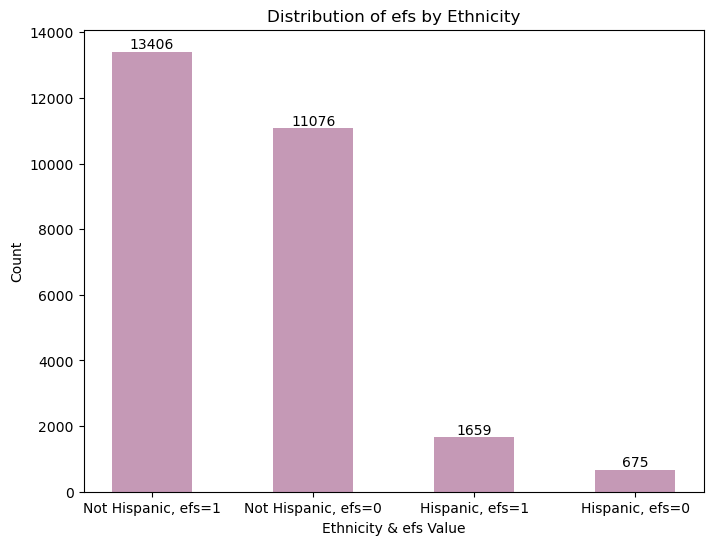

In [4]:
not_hispanic_efs_1 = df[(df["ethnicity"] == "Not Hispanic or Latino") & (df["efs"] == 1)].shape[0]
not_hispanic_efs_0 = df[(df["ethnicity"] == "Not Hispanic or Latino") & (df["efs"] == 0)].shape[0]
hispanic_efs_1 = df[(df["ethnicity"] == "Hispanic or Latino") & (df["efs"] == 1)].shape[0]
hispanic_efs_0 = df[(df["ethnicity"] == "Hispanic or Latino") & (df["efs"] == 0)].shape[0]

labels = ["Not Hispanic, efs=1", "Not Hispanic, efs=0", "Hispanic, efs=1", "Hispanic, efs=0"]
values = [not_hispanic_efs_1, not_hispanic_efs_0, hispanic_efs_1, hispanic_efs_0]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, width=0.5, color="#C599B6")

plt.xlabel("Ethnicity & efs Value")
plt.ylabel("Count")
plt.title("Distribution of efs by Ethnicity")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha="center", va="bottom", fontsize=10)

plt.savefig("distribution.png", dpi=300, bbox_inches="tight", pad_inches=0.05)
plt.show()

#### Here we do some fillna operations for the null values and use labelencoder for simple features engineering

In [5]:
cat_cols = []
num_cols = []

TARGET = ["efs"]
FEATURES = [c for c in df.columns if c not in TARGET]

for c in FEATURES:
    if df[c].dtype == "object" or df[c].dtype == "category":
        cat_cols.append(c)
    else:
        num_cols.append(c)
print(f"In these features, there are {len(cat_cols)} CATEGORICAL FEATURES: {cat_cols}")


def update(df, cat_cols):
    for c in cat_cols:
        df[c] = df[c].astype(str).fillna("Unknown").astype("category")
    for c in num_cols:
        if df[c].dtype == "float64":
            df[c] = df[c].fillna(0).astype("float32")
        if df[c].dtype == "int64":
            df[c] = df[c].fillna(0).astype("int32")
    return df


df["efs"] = df["efs"].astype("int32")
df = update(df, cat_cols)
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))
df.sample(frac=1.0).reset_index(drop=True, inplace=True)
df.head()

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs
0,2,0,1,0,2.0,8.0,6,0,6.0,1,...,0,4,2,1,8.0,0,2.0,3,10.0,1
1,2,0,1,0,2.0,8.0,0,0,6.0,1,...,0,1,3,1,8.0,0,2.0,0,9.0,1
2,2,0,1,3,2.0,8.0,0,0,6.0,1,...,0,4,3,1,8.0,3,2.0,0,10.0,1
3,0,0,6,3,2.0,8.0,0,0,6.0,1,...,0,4,3,0,8.0,0,2.0,3,10.0,1
4,8,0,2,0,2.0,8.0,0,0,6.0,0,...,0,3,2,0,8.0,0,2.0,0,10.0,1


#### Here we set the sensitive attribute to be "ethnicity" and split the dataset into df and test set

In [6]:
df["ethnicity"].value_counts()

ethnicity
1    24482
0     2334
Name: count, dtype: int64

In [7]:
features = [c for c in df.columns if c not in TARGET]
sensitive_attribute = features.index("ethnicity")
print(sensitive_attribute)

target = ["efs"]

X = df[features]
y = df[target]

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_train = y_train_df.to_numpy().ravel()
y_test = y_test_df.to_numpy().ravel()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

27
(24134, 57) (24134,)
(2682, 57) (2682,)


#### Here we report the per-group prevalance for z=0 and z=1

In [8]:
z_test = (X_test[:, sensitive_attribute] == 1)

prevalence_0 = np.mean(y_test[z_test == 0])
prevalence_1 = np.mean(y_test[z_test == 1])

prevalence_0, prevalence_1

(0.726890756302521, 0.5495090016366612)

#### Here we train the basic model and report the demographic parity on the test set

In [9]:
model = LogisticRegression(C=1, max_iter=5000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc: .4f}")

z_test = (X_test[:, sensitive_attribute] == 1)

positive_pred_z_0 = np.mean(y_pred[z_test == 0])
positive_pred_z_1 = np.mean(y_pred[z_test == 1])

parity = positive_pred_z_0 / positive_pred_z_1
parity

Accuracy:  0.6659


1.335418472321664

#### Here we report TPR_0, TPR_1, FPR_0, and FPR_1

In [10]:
z_test = (X_test[:, sensitive_attribute] == 1)

tp_0 = np.sum((y_pred == 1) & (y_test == 1) & (z_test == 0))
fn_0 = np.sum((y_pred == 0) & (y_test == 1) & (z_test == 0))
fp_0 = np.sum((y_pred == 1) & (y_test == 0) & (z_test == 0))
tn_0 = np.sum((y_pred == 0) & (y_test == 0) & (z_test == 0))

tp_1 = np.sum((y_pred == 1) & (y_test == 1) & (z_test == 1))
fn_1 = np.sum((y_pred == 0) & (y_test == 1) & (z_test == 1))
fp_1 = np.sum((y_pred == 1) & (y_test == 0) & (z_test == 1))
tn_1 = np.sum((y_pred == 0) & (y_test == 0) & (z_test == 1))

TPR_0 = tp_0 / (tp_0 + fn_0)
TPR_1 = tp_1 / (tp_1 + fn_1)

FPR_0 = fp_0 / (fp_0 + tn_0)
FPR_1 = fp_1 / (fp_1 + tn_1)

TPR_0, TPR_1, FPR_0, FPR_1

(0.8959537572254336,
 0.7721518987341772,
 0.7384615384615385,
 0.47593097184377836)

#### Now we try data-based method

In [11]:
train_df = pd.concat([X_train_df, y_train_df], axis=1)

print(train_df[(train_df["ethnicity"] == 1) & (train_df["efs"] == 1)].shape)
print(train_df[(train_df["ethnicity"] == 1) & (train_df["efs"] == 0)].shape)
print(train_df[(train_df["ethnicity"] == 0) & (train_df["efs"] == 1)].shape)
print(train_df[(train_df["ethnicity"] == 0) & (train_df["efs"] == 0)].shape)

(12063, 58)
(9975, 58)
(1486, 58)
(610, 58)


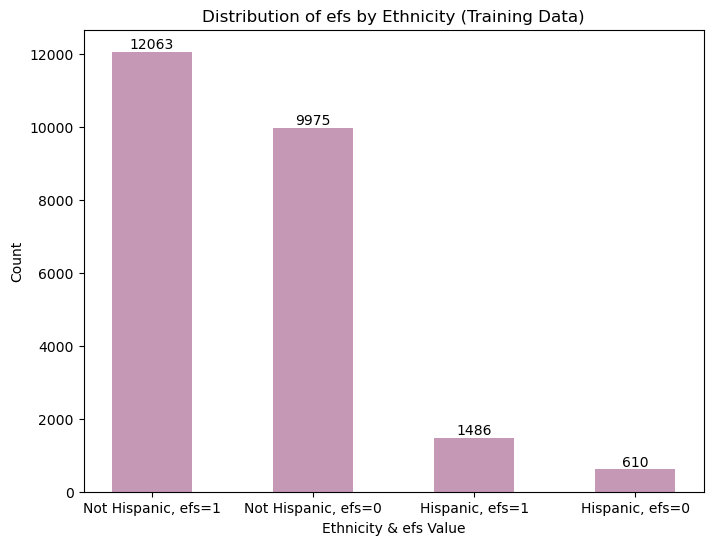

In [12]:
not_hispanic_efs_1 = train_df[(train_df["ethnicity"] == 1) & (train_df["efs"] == 1)].shape[0]
not_hispanic_efs_0 = train_df[(train_df["ethnicity"] == 1) & (train_df["efs"] == 0)].shape[0]
hispanic_efs_1 = train_df[(train_df["ethnicity"] == 0) & (train_df["efs"] == 1)].shape[0]
hispanic_efs_0 = train_df[(train_df["ethnicity"] == 0) & (train_df["efs"] == 0)].shape[0]

labels = ["Not Hispanic, efs=1", "Not Hispanic, efs=0", "Hispanic, efs=1", "Hispanic, efs=0"]
values = [not_hispanic_efs_1, not_hispanic_efs_0, hispanic_efs_1, hispanic_efs_0]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, width=0.5, color="#C599B6")

plt.xlabel("Ethnicity & efs Value")
plt.ylabel("Count")
plt.title("Distribution of efs by Ethnicity (Training Data)")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha="center", va="bottom", fontsize=10)

plt.savefig("train_distribution.png", dpi=300, bbox_inches="tight", pad_inches=0.05)
plt.show()

In [13]:
part_1 = train_df[(train_df["ethnicity"] == 1) & (train_df["efs"] == 1)]
part_2 = train_df[(train_df["ethnicity"] == 1) & (train_df["efs"] == 0)]
part_3 = train_df[(train_df["ethnicity"] == 0) & (train_df["efs"] == 1)]
part_4 = train_df[(train_df["ethnicity"] == 0) & (train_df["efs"] == 0)]

part_1_downsampled = resample(part_1, replace=False, n_samples=len(part_2), random_state=42)
part_4_upsampled = resample(part_4, replace=True, n_samples=len(part_3), random_state=42)

# part_1_downsampled = resample(part_1, replace=False, n_samples=len(part_4), random_state=42)
# part_2_downsampled = resample(part_2, replace=False, n_samples=len(part_4), random_state=42)
# part_3_downsampled = resample(part_3, replace=False, n_samples=len(part_4), random_state=42)

train_df_balanced = pd.concat([part_1_downsampled, part_2, part_3, part_4_upsampled])

# train_df_balanced = pd.concat([part_1_downsampled, part_2_downsampled, part_3_downsampled, part_4])

train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print(train_df_balanced.shape)

(22922, 58)


In [14]:
X_train_df_balanced = train_df_balanced.iloc[:, :-1]
y_train_df_balanced = train_df_balanced.iloc[:, -1]

X_train_balanced = X_train_df_balanced.to_numpy()
y_train_balanced = y_train_df_balanced.to_numpy().ravel()

In [15]:
new_model_1 = LogisticRegression(C=1, max_iter=5000, random_state=42)
new_model_1.fit(X_train_balanced, y_train_balanced)
y_pred = new_model_1.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc: .4f}")

z_test = (X_test[:, sensitive_attribute] == 1)

positive_pred_z_0 = np.mean(y_pred[z_test == 0])
positive_pred_z_1 = np.mean(y_pred[z_test == 1])

parity = positive_pred_z_0 / positive_pred_z_1
parity

Accuracy:  0.6532


1.0215143649082672

In [16]:
z_test = (X_test[:, sensitive_attribute] == 1)

tp_0 = np.sum((y_pred == 1) & (y_test == 1) & (z_test == 0))
fn_0 = np.sum((y_pred == 0) & (y_test == 1) & (z_test == 0))
fp_0 = np.sum((y_pred == 1) & (y_test == 0) & (z_test == 0))
tn_0 = np.sum((y_pred == 0) & (y_test == 0) & (z_test == 0))

tp_1 = np.sum((y_pred == 1) & (y_test == 1) & (z_test == 1))
fn_1 = np.sum((y_pred == 0) & (y_test == 1) & (z_test == 1))
fp_1 = np.sum((y_pred == 1) & (y_test == 0) & (z_test == 1))
tn_1 = np.sum((y_pred == 0) & (y_test == 0) & (z_test == 1))

TPR_0 = tp_0 / (tp_0 + fn_0)
TPR_1 = tp_1 / (tp_1 + fn_1)

FPR_0 = fp_0 / (fp_0 + tn_0)
FPR_1 = fp_1 / (fp_1 + tn_1)

TPR_0, TPR_1, FPR_0, FPR_1

(0.6184971098265896, 0.6857781087118392, 0.4, 0.37783832879200724)

#### Now we try reweighting method

In [17]:
group_counts = train_df.groupby(["ethnicity", "efs"]).size()
group_probs = group_counts / len(train_df)


def compute_weight(row):
    return 1 / group_probs[(row["ethnicity"], row["efs"])]


train_df["weight"] = train_df.apply(compute_weight, axis=1)
print(train_df["weight"].value_counts())

weight
2.000663     12063
2.419449      9975
16.240915     1486
39.563934      610
Name: count, dtype: int64


In [18]:
X_train_df_reweighted = train_df.drop(columns=["efs", "weight"])
y_train_df_reweighted = train_df["efs"]
sample_weights = train_df["weight"]

X_train_reweighted = X_train_df_reweighted.to_numpy()
y_train_reweighted = y_train_df_reweighted.to_numpy().ravel()

In [19]:
new_model_2 = LogisticRegression(C=1, max_iter=5000, random_state=42)
new_model_2.fit(X_train_reweighted, y_train_reweighted, sample_weight=sample_weights)
y_pred = new_model_2.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc: .4f}")

z_test = (X_test[:, sensitive_attribute] == 1)

positive_pred_z_0 = np.mean(y_pred[z_test == 0])
positive_pred_z_1 = np.mean(y_pred[z_test == 1])

parity = positive_pred_z_0 / positive_pred_z_1
parity

Accuracy:  0.6514


1.0245622058347148

In [20]:
z_test = (X_test[:, sensitive_attribute] == 1)

tp_0 = np.sum((y_pred == 1) & (y_test == 1) & (z_test == 0))
fn_0 = np.sum((y_pred == 0) & (y_test == 1) & (z_test == 0))
fp_0 = np.sum((y_pred == 1) & (y_test == 0) & (z_test == 0))
tn_0 = np.sum((y_pred == 0) & (y_test == 0) & (z_test == 0))

tp_1 = np.sum((y_pred == 1) & (y_test == 1) & (z_test == 1))
fn_1 = np.sum((y_pred == 0) & (y_test == 1) & (z_test == 1))
fp_1 = np.sum((y_pred == 1) & (y_test == 0) & (z_test == 1))
tn_1 = np.sum((y_pred == 0) & (y_test == 0) & (z_test == 1))

TPR_0 = tp_0 / (tp_0 + fn_0)
TPR_1 = tp_1 / (tp_1 + fn_1)

FPR_0 = fp_0 / (fp_0 + tn_0)
FPR_1 = fp_1 / (fp_1 + tn_1)

TPR_0, TPR_1, FPR_0, FPR_1

(0.6069364161849711,
 0.6798212956068503,
 0.4153846153846154,
 0.3723887375113533)

#### Now we use post-processing method

In [21]:
def compute_rates(y_true, y_scores, threshold):
    y_scores = np.array(y_scores)
    preds = (y_scores >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return tpr, fpr


y_pred_probs = model.predict_proba(X_test)[:, 1]

z_test_0 = np.where(X_test[:, sensitive_attribute] == 0)[0]
z_test_1 = np.where(X_test[:, sensitive_attribute] == 1)[0]


def get_optimal_threshold(y_true_0, scores_0, y_true_1, scores_1, base_thresh=0.5):
    tpr_0, _ = compute_rates(y_true_0, scores_0, base_thresh)
    tpr_1, _ = compute_rates(y_true_1, scores_1, base_thresh)

    if tpr_0 == tpr_1:
        return base_thresh

    if tpr_0 < tpr_1:
        print("Lower TPR group: 0")
        y_lower_group = y_true_0
        scores_lower_group = scores_0
        fixed_tpr = tpr_1
    else:
        print("Lower TPR group: 1")
        y_lower_group = y_true_1
        scores_lower_group = scores_1
        fixed_tpr = tpr_0

    min_diff = float("inf")
    optimal_thresh = base_thresh

    thresholds = sorted(set(scores_lower_group), reverse=True)
    for thresh in tqdm(thresholds, total=len(thresholds)):
        new_tpr, _ = compute_rates(y_lower_group, scores_lower_group, thresh)
        if abs(new_tpr - fixed_tpr) < min_diff:
            optimal_thresh = thresh
            min_diff = abs(new_tpr - fixed_tpr)

    return optimal_thresh


optimal_threshold = get_optimal_threshold(y_test[z_test_0], y_pred_probs[z_test_0], y_test[z_test_1], y_pred_probs[z_test_1])
print(f"Optimal Threshold: {optimal_threshold}")

Lower TPR group: 1


100%|██████████| 2444/2444 [00:01<00:00, 1227.88it/s]

Optimal Threshold: 0.39266323188008745


In [22]:
y_pred_adjusted = np.zeros_like(y_test)

y_pred_adjusted[z_test_0] = (y_pred_probs[z_test_0] >= 0.5).astype(int)
y_pred_adjusted[z_test_1] = (y_pred_probs[z_test_1] >= optimal_threshold).astype(int)

acc_adjusted = accuracy_score(y_test, y_pred_adjusted)

print(f"Adjusted Accuracy: {acc_adjusted:.4f}")

Adjusted Accuracy: 0.6555


In [23]:
tpr_0, fpr_0 = compute_rates(y_test[z_test_0], y_pred_probs[z_test_0], 0.5)
tpr_1, fpr_1 = compute_rates(y_test[z_test_1], y_pred_probs[z_test_1], optimal_threshold)

print(f"Adjusted TPR_0: {tpr_0}, Adjusted FPR_0: {fpr_0}")
print(f"Adjusted TPR_1: {tpr_1}, Adjusted FPR_1: {fpr_1}")

Adjusted TPR_0: 0.8959537572254336, Adjusted FPR_0: 0.7384615384615385
Adjusted TPR_1: 0.8957557706626954, Adjusted FPR_1: 0.6521344232515894


#### Use the method in the paper

In [24]:
class FairLogisticRegression:
    def __init__(self, C=1, max_iter=5000, fairness_weight=1.0):
        self.C = C
        self.max_iter = max_iter
        self.fairness_weight = fairness_weight
        self.coef_ = None
        self.intercept_ = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fairness_loss(self, coef, X, y, sensitive_attr):
        logits = X @ coef
        y_pred_prob = self.sigmoid(logits)

        log_loss = -np.mean(y * np.log(y_pred_prob + 1e-9) + (1 - y) * np.log(1 - y_pred_prob + 1e-9))

        pos_rate_0 = np.mean(y_pred_prob[sensitive_attr == 0])
        pos_rate_1 = np.mean(y_pred_prob[sensitive_attr == 1])
        fairness_penalty = (pos_rate_0 - pos_rate_1) ** 2

        return log_loss + self.fairness_weight * fairness_penalty

    def fit(self, X, y, sensitive_attr):
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        initial_coef = np.zeros(X.shape[1])

        result = minimize(
            self.fairness_loss,
            initial_coef,
            args=(X, y, sensitive_attr),
            method="L-BFGS-B"
        )

        self.coef_ = result.x[:-1].reshape(1, -1)
        self.intercept_ = result.x[-1]

    def predict(self, X):
        logits = X @ self.coef_.T + self.intercept_
        return (self.sigmoid(logits).flatten() > 0.5).astype(int)

In [25]:
fair_model = FairLogisticRegression(fairness_weight=0.8)
fair_model.fit(X_train, y_train, X_train[:, sensitive_attribute])
y_pred = fair_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc: .4f}")

positive_pred_z_0 = np.mean(y_pred[z_test == 0])
positive_pred_z_1 = np.mean(y_pred[z_test == 1])

parity_fair = positive_pred_z_0 / positive_pred_z_1
print(f"Fair Model Parity: {parity_fair}")

Accuracy:  0.6611
Fair Model Parity: 0.9788934023794019


In [26]:
z_test = (X_test[:, sensitive_attribute] == 1)

tp_0 = np.sum((y_pred == 1) & (y_test == 1) & (z_test == 0))
fn_0 = np.sum((y_pred == 0) & (y_test == 1) & (z_test == 0))
fp_0 = np.sum((y_pred == 1) & (y_test == 0) & (z_test == 0))
tn_0 = np.sum((y_pred == 0) & (y_test == 0) & (z_test == 0))

tp_1 = np.sum((y_pred == 1) & (y_test == 1) & (z_test == 1))
fn_1 = np.sum((y_pred == 0) & (y_test == 1) & (z_test == 1))
fp_1 = np.sum((y_pred == 1) & (y_test == 0) & (z_test == 1))
tn_1 = np.sum((y_pred == 0) & (y_test == 0) & (z_test == 1))

TPR_0 = tp_0 / (tp_0 + fn_0)
TPR_1 = tp_1 / (tp_1 + fn_1)

FPR_0 = fp_0 / (fp_0 + tn_0)
FPR_1 = fp_1 / (fp_1 + tn_1)

TPR_0, TPR_1, FPR_0, FPR_1

(0.7052023121387283,
 0.7982129560685034,
 0.5076923076923077,
 0.5031789282470481)